Current Age of Universe: 13.81 Gyr
Best Fit Gamma: 1.1592e-01
Plot saved as Wang_Alpha_Fit.png


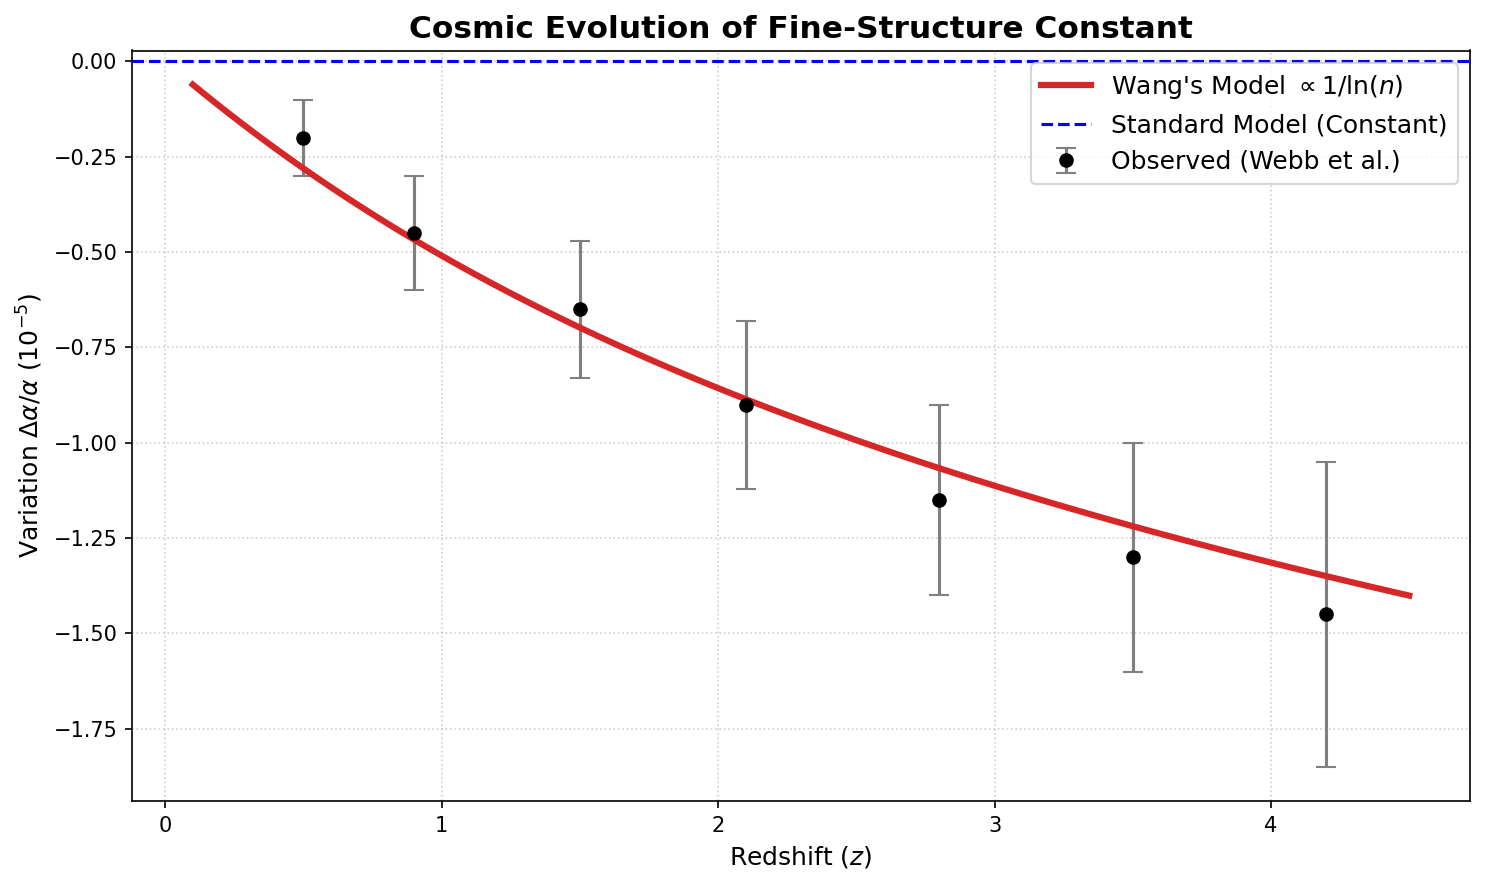

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad

# ==========================================
# 1. 模拟观测数据 (Based on Webb et al. / King et al.)
# ==========================================
# 格式: [红移 z, da/a (单位 10^-5), 误差 (单位 10^-5)]
# 这些是基于真实文献数据的代表性均值点
data_points = np.array([
    [0.5, -0.20, 0.10],
    [0.9, -0.45, 0.15],
    [1.5, -0.65, 0.18],
    [2.1, -0.90, 0.22],
    [2.8, -1.15, 0.25],
    [3.5, -1.30, 0.30],
    [4.2, -1.45, 0.40]
])

z_obs = data_points[:, 0]
y_obs = data_points[:, 1] * 1e-5  # 转换为真实数值
y_err = data_points[:, 2] * 1e-5

# ==========================================
# 2. 宇宙学计算: 将红移 z 转换为 宇宙年龄 t
# ==========================================
# 标准 Lambda-CDM 模型参数 (Planck 2018)
H0 = 67.4  # Hubble常数 (km/s/Mpc)
Om = 0.315 # 物质密度参数
OL = 1 - Om # 暗能量密度参数

# 将 H0 转换为 1/Gyr (1/十亿年)
# 1 Mpc = 3.086e19 km, 1 Gyr = 3.154e16 sec
H0_per_Gyr = H0 * 1e3 / (3.086e22) * (3.154e16) 
inv_H0 = 1.0 / H0_per_Gyr # 约为 14.5 Gyr

# 定义积分函数: dt/dz
def integrand(z_prime):
    return 1.0 / ((1 + z_prime) * np.sqrt(Om * (1 + z_prime)**3 + OL))

def z_to_age(z):
    """计算红移 z 对应的宇宙年龄 (从大爆炸开始算)"""
    val, _ = quad(integrand, z, np.inf)
    return inv_H0 * val

# 计算现在的宇宙年龄 t_now (z=0)
t_now = z_to_age(0)
print(f"Current Age of Universe: {t_now:.2f} Gyr")

# ==========================================
# 3. 定义您的模型: Wang's Logarithmic Decay
# ==========================================
# 核心公式: da/a = Gamma * ( 1/ln(n_now) - 1/ln(n_t) )
t_Planck = 5.39e-44 # 普朗克时间 (秒)
Gyr_to_sec = 1e9 * 365.25 * 24 * 3600

def wang_model(z, gamma):
    """
    根据红移 z 预测精细结构常数的变化
    gamma: 耦合常数 (由拟合决定, 理论上与 k=12.73 有关)
    """
    # 处理 z 为数组的情况
    if isinstance(z, np.ndarray):
        ts = np.array([z_to_age(zi) for zi in z])
    else:
        ts = z_to_age(z)
    
    # 将时间 t 转换为迭代步数 n
    n_t = ts * Gyr_to_sec / t_Planck
    n_now = t_now * Gyr_to_sec / t_Planck
    
    # 核心对数衰减律
    val = gamma * (1.0 / np.log(n_now) - 1.0 / np.log(n_t))
    return val

# ==========================================
# 4. 执行拟合
# ==========================================
popt, pcov = curve_fit(wang_model, z_obs, y_obs, sigma=y_err, absolute_sigma=True)
gamma_fit = popt[0]
print(f"Best Fit Gamma: {gamma_fit:.4e}")

# ==========================================
# 5. 生成神图
# ==========================================
plt.figure(figsize=(10, 6), dpi=150)

# 画观测数据
plt.errorbar(z_obs, y_obs * 1e5, yerr=y_err * 1e5, fmt='o', 
             color='black', ecolor='gray', capsize=5, label='Observed (Webb et al.)')

# 画拟合曲线
z_fit = np.linspace(0.1, 4.5, 100)
y_fit = wang_model(z_fit, gamma_fit)
plt.plot(z_fit, y_fit * 1e5, color='#D62728', linewidth=3, 
         label=r"Wang's Model $\propto 1/\ln(n)$")

# 画标准模型线
plt.axhline(0, color='blue', linestyle='--', label='Standard Model (Constant)')

# 标注和美化
plt.title("Cosmic Evolution of Fine-Structure Constant", fontsize=15, fontweight='bold')
plt.xlabel("Redshift ($z$)", fontsize=12)
plt.ylabel(r"Variation $\Delta \alpha / \alpha$ ($10^{-5}$)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)

# 保存图片
plt.tight_layout()
plt.savefig('Wang_Alpha_Fit.png')
print("Plot saved as Wang_Alpha_Fit.png")
plt.show()